# SD212: Graph mining
## Lab 4: Graph clustering

In this lab, you will learn to cluster a graph and interpret the results. 

## Import

In [1]:
from IPython.display import SVG

In [2]:
import numpy as np
from scipy import sparse

In [3]:
!pip install scikit_network

     |████████████████████████████████| 2.3MB 3.4MB/s 


In [4]:
# if you get any error, please update scikit-network!
from sknetwork.data import load_netset, karate_club
from sknetwork.clustering import Louvain, BiLouvain, modularity
from sknetwork.ranking import PageRank, BiPageRank
from sknetwork.linalg import normalize
from sknetwork.utils import membership_matrix
from sknetwork.visualization import svg_graph, svg_digraph

## Data

We will work on the following graphs (see the [NetSets](https://graphs.telecom-paristech.fr/Home_page.html#netsets-section) collection for details):
* Openflights (graph)
* WikiVitals (digraph)
* Cinema (bigraph)

In [5]:
openflights = load_netset('openflights')
wikivitals = load_netset('wikivitals')
cinema = load_netset('cinema')

## 1. Graphs

The Louvain algorithm aims at maximizing [modularity](https://en.wikipedia.org/wiki/Modularity_(networks)).

In [ ]:
from sknetwork.utils import membership_matrix, directed2undirected, Bunch

def grid(n1: int = 10, n2: int = 10, metadata: bool = False):
    """Grid (undirected).
    Parameters
    ----------
    n1, n2 : int
        Grid dimension.
    metadata : bool
        If ``True``, return a `Bunch` object with metadata.
    Returns
    -------
    adjacency or graph : Union[sparse.csr_matrix, Bunch]
        Adjacency matrix or graph with metadata (positions).
    Example
    -------
    >>> from sknetwork.data import grid
    >>> adjacency = grid(10, 5)
    >>> adjacency.shape
    (50, 50)
    """
    nodes = [(i1, i2) for i1 in range(n1) for i2 in range(n2)]
    edges = [((i1, i2), (i1 + 1, i2)) for i1 in range(n1 - 1) for i2 in range(n2)]
    edges += [((i1, i2), (i1, i2 + 1)) for i1 in range(n1) for i2 in range(n2 - 1)]
    node_id = {u: i for i, u in enumerate(nodes)}
    edges = list(map(lambda edge: (node_id[edge[0]], node_id[edge[1]]), edges))
    adjacency = edgelist2adjacency(edges, undirected=True)
    if metadata:
        graph = Bunch()
        graph.adjacency = adjacency
        graph.position = np.array(nodes)
        return graph
    else:
        return adjacency
    
def edgelist2adjacency(edgelist: list, undirected: bool = False) -> sparse.csr_matrix:
    """Build an adjacency matrix from a list of edges.
    Parameters
    ----------
    edgelist : list
        List of edges as pairs (i, j) or triplets (i, j, w) for weighted edges.
    undirected : bool
        If ``True``, return a symmetric adjacency.
    Returns
    -------
    adjacency : sparse.csr_matrix
    Examples
    --------
    >>> edgelist = [(0, 1), (1, 2), (2, 0)]
    >>> adjacency = edgelist2adjacency(edgelist)
    >>> adjacency.shape, adjacency.nnz
    ((3, 3), 3)
    >>> adjacency = edgelist2adjacency(edgelist, undirected=True)
    >>> adjacency.shape, adjacency.nnz
    ((3, 3), 6)
    >>> weighted_edgelist = [(0, 1, 0.2), (1, 2, 4), (2, 0, 1.3)]
    >>> adjacency = edgelist2adjacency(weighted_edgelist)
    >>> adjacency.dtype
    dtype('float64')
    """
    edges = np.array(edgelist)
    row, col = edges[:, 0].astype(np.int32), edges[:, 1].astype(np.int32)
    n = max(row.max(), col.max()) + 1
    if edges.shape[1] > 2:
        data = edges[:, 2]
    else:
        data = np.ones_like(row, dtype=bool)
    adjacency = sparse.csr_matrix((data, (row, col)), shape=(n, n))
    if undirected:
        adjacency = directed2undirected(adjacency)
    return adjacency

## Grid

Consider a grid:

In [ ]:
graph = grid(9, 9, True)
adjacency = graph.adjacency
position = graph.position

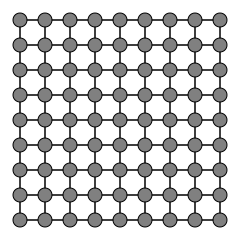

In [ ]:
image = svg_graph(adjacency, position, width=200, height=200)
SVG(image)

## To do

* Cluster the graph by Louvain and display it with the labels.
* What is the modularity?
* Try the ``shuffle_nodes`` option and observe the results.
* Find a better clustering than Louvain in terms of modularity. **Hint:** Guess and calculate!

In [ ]:
louvain = Louvain()
labels = louvain.fit_transform(adjacency)

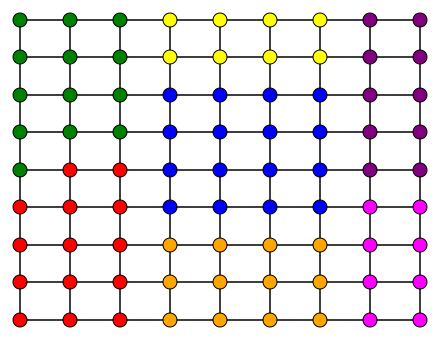

In [ ]:
image = svg_graph(adjacency, position, labels=labels)
SVG(image)

In [ ]:
modularity(adjacency,labels)

0.6220341435185185

0.6333429783950617


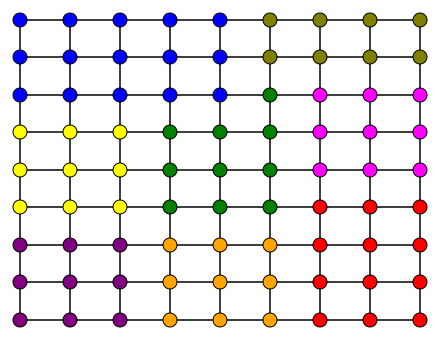

In [ ]:
louvain = Louvain(shuffle_nodes=True)
labels = louvain.fit_transform(adjacency)
image = svg_graph(adjacency, position, labels=labels)
print(modularity(adjacency,labels))
SVG(image)

La partie devinette je sais pas trop

## Karate Club


The [karate club graph](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) provides ground-truth clusters.

In [ ]:
graph = karate_club(True)

In [ ]:
adjacency = graph.adjacency
position = graph.position
labels_true = graph.labels

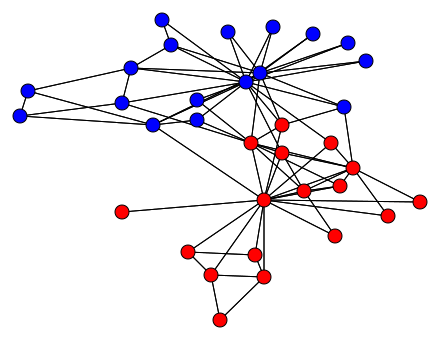

In [ ]:
image = svg_graph(adjacency, position, labels=labels_true)
SVG(image)

## To do

* Cluster the graph by Louvain and display the labels.
* What is the modularity?
* Display the aggregate graph.
* Adapt the resolution to get 2 clusters. How many nodes are misclassified?

In [ ]:

louvain = Louvain(resolution=0.5)
#louvain = Louvain()

In [ ]:
labels = louvain.fit_transform(adjacency)

0.3717948717948718


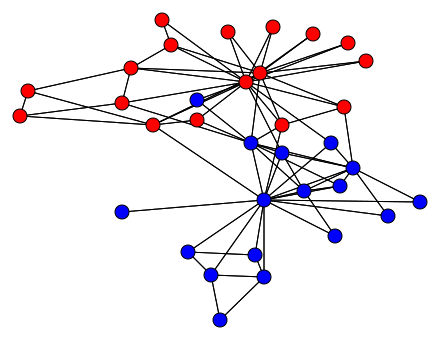

In [ ]:
image = svg_graph(adjacency, position, labels=labels)
print(modularity(adjacency,labels))
SVG(image)

In [ ]:
np.abs(labels-labels_true)

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
adjacency_aggregate = louvain.adjacency_

In [ ]:
average = normalize(membership_matrix(labels).T)
position_aggregate = average.dot(position)

In [ ]:
labels_unique, counts = np.unique(labels, return_counts=True)

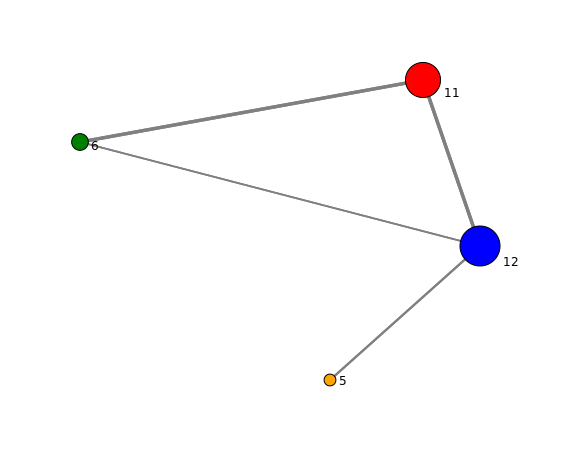

In [ ]:
image = svg_graph(adjacency_aggregate, position_aggregate, names=counts, labels=labels_unique, display_node_weight=True)
SVG(image)

## Openflights


In [10]:
graph = openflights

In [11]:
adjacency = graph.adjacency
position = graph.position
names = graph.names

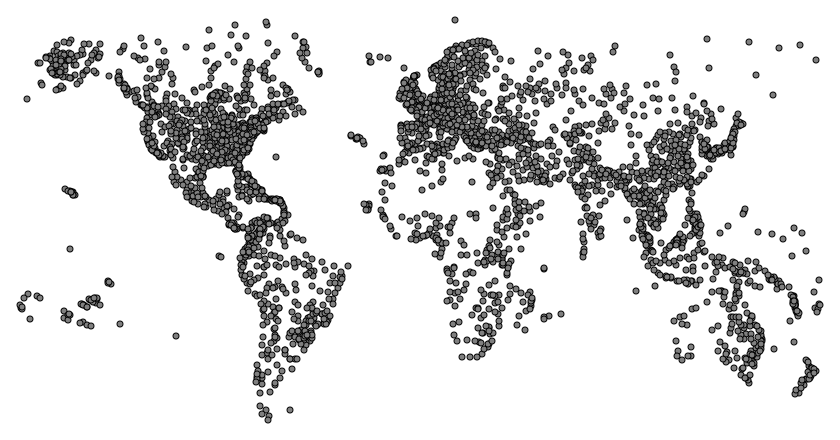

In [12]:
image = svg_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

## To do

* Display the same world map with the clusters found by Louvain (resolution 1).
* How many clusters are there?
* What is the Simpson index of this clustering? Check the parameters of the function ``modularity``.
* How do you interpret the *inverse* of the Simpson index?
* List the top airport of each cluster in number of flights.
* Display the aggregate graph with the cluster volumes and the name of the top airport of each cluster.
* What is the strongest cluster among those having more than 100 nodes? **Hint:** Use the aggregate graph.

0.6547379865067756


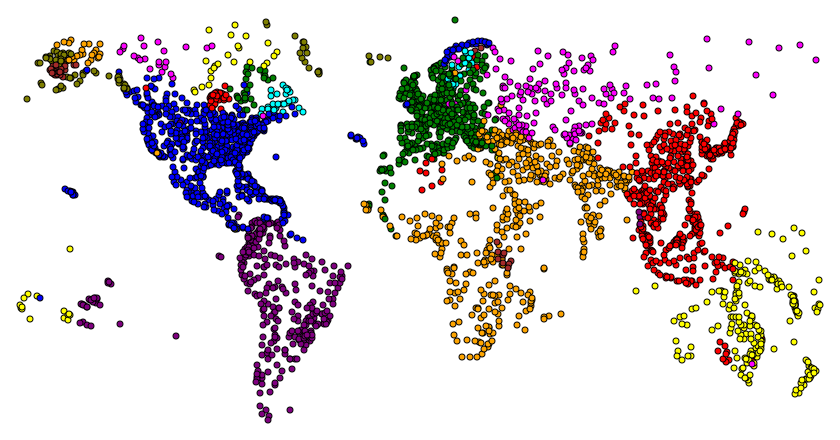

In [13]:
louvain = Louvain(resolution=1)
labels = louvain.fit_transform(adjacency)
image = svg_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False,labels=labels)
print(modularity(adjacency,labels))
SVG(image)

In [14]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34])

In [15]:
modularity(adjacency,labels,return_all=True)

(0.6547379865067756, 0.8702285399178972, 0.21549055341112153)

In [18]:
A = adjacency.toarray()
degrees = np.dot(A,np.ones(len(names)))

In [20]:
new_names = []
for i in range(35):
    indexes=np.argwhere(labels==i)
    b=np.argmax(degrees[indexes])
    c=indexes[b]
    new_names.append(names[c[0]])

new_names = np.array(new_names)

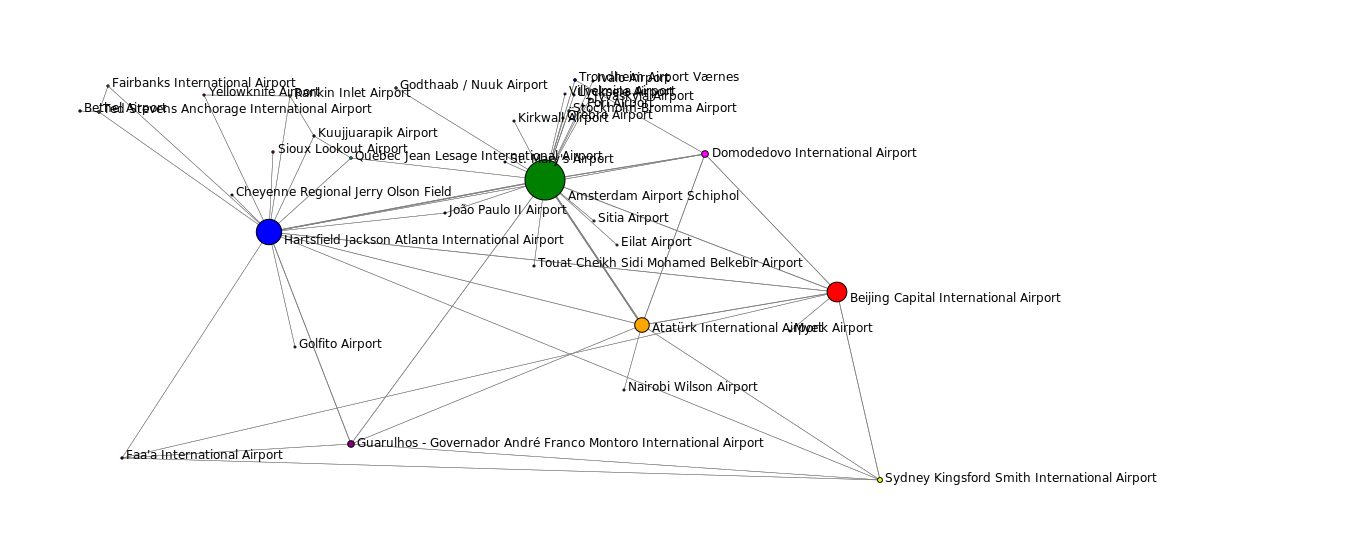

In [22]:
adjacency_aggregate = louvain.adjacency_
average = normalize(membership_matrix(labels).T)
position_aggregate = average.dot(position)
labels_unique, counts = np.unique(labels, return_counts=True)
image = svg_graph(adjacency_aggregate, position_aggregate, width=800, height=400,names=new_names, labels=labels_unique, display_node_weight=True)
SVG(image)

In [23]:
A = adjacency_aggregate.toarray()
strengths = np.diag(A) / np.sum(A,axis=1)

In [ ]:
indexes = np.argwhere(counts>100).flatten()

In [ ]:
np.argmax(strengths[indexes])

1

In [ ]:
new_names[np.argwhere(labels_unique==1)]

array([['Beijing Capital International Airport']], dtype='<U65')

## 2. Digraphs

## Wikipedia Vitals

## To do

* Cluster the graph by Louvain (resolution 1).
* List the top-5 pages of each cluster in terms of Personalized PageRank (with restart in the cluster).
* Display the aggregate graph with the cluster volumes and the name of the top page of each cluster.
* What is the strongest cluster? the weakest cluster?
* Do the same experiments at resolution 2.

In [24]:
graph = wikivitals

In [25]:
adjacency = graph.adjacency
names = graph.names

In [26]:
louvain = Louvain(resolution=1)
labels = louvain.fit_transform(adjacency)
pagerank = PageRank()

In [ ]:
top_pages = []
for label in np.unique(labels):
    cluster = np.where(labels == label)[0]
    seeds = {node : 1 for node in cluster}
    scores = pagerank.fit_transform(adjacency,seeds)
    top_nodes = cluster[np.argsort(-scores[cluster])[0:5]]
    print(names[top_nodes])
    top_pages.append(names[top_nodes[0]])

['Taxonomy (biology)' 'Animal' 'Protein' 'Plant' 'Bacteria']
['Mathematics' 'Physics' 'Oxygen' 'Hydrogen' 'Earth']
['United States' 'Geographic coordinate system' 'France' 'United Kingdom'
 'World War II']
['Latin' 'Christianity' 'Greek language' 'Roman Empire' 'Middle Ages']
['Chinese language' 'Europe' 'Ottoman Empire' 'Russian Empire'
 'Qing dynasty']
['Bibliothèque nationale de France' 'The New York Times'
 'Encyclopædia Britannica' 'BBC' 'Time (magazine)']
['Common law' 'Marriage' 'Economics' 'Incest' 'Contract']


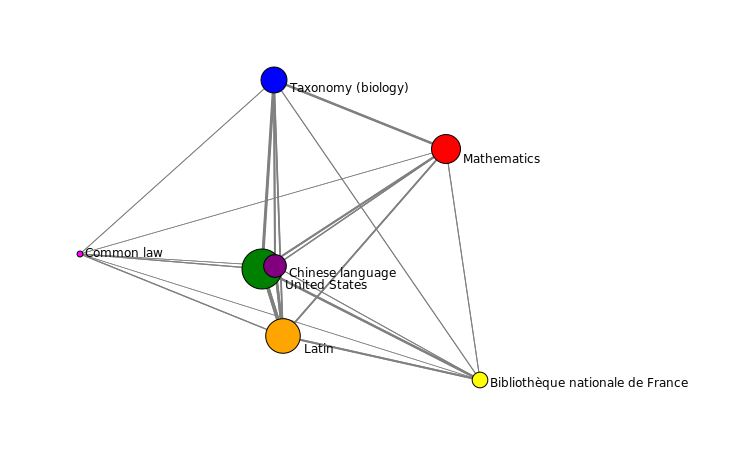

In [ ]:
adjacency_aggregate = louvain.adjacency_
average = normalize(membership_matrix(labels).T)
labels_unique, counts = np.unique(labels, return_counts=True)
image = svg_graph(adjacency_aggregate, names=top_pages, labels=labels_unique, display_node_weight=True)
SVG(image)

In [ ]:
A = adjacency_aggregate.toarray()
strengths = np.diag(A) / np.sum(A,axis=1)
np.argmax(strengths)

1

In [ ]:
top_pages[1]

'Mathematics'

In [ ]:
np.argmax(-strengths)

6

In [ ]:
top_pages[6]

'Common law'

In [ ]:
louvain = Louvain(resolution=2)
labels = louvain.fit_transform(adjacency)
pagerank = PageRank()
top_pages = []
for label in np.unique(labels):
    cluster = np.where(labels == label)[0]
    seeds = {node : 1 for node in cluster}
    scores = pagerank.fit_transform(adjacency,seeds)
    top_nodes = cluster[np.argsort(-scores[cluster])[0:5]]
    print(names[top_nodes])
    top_pages.append(names[top_nodes[0]])
  

['Taxonomy (biology)' 'Animal' 'Protein' 'Chordate' 'Plant']
['Bibliothèque nationale de France' 'Encyclopædia Britannica'
 'Romanticism' 'Jazz' 'Modernism']
['Oxygen' 'Hydrogen' 'Electron' 'Carbon' 'Nitrogen']
['Roman Empire' 'Ottoman Empire' 'Byzantine Empire' 'Middle Ages'
 'Holy Roman Empire']
['United States' 'Germany' 'New York City' 'Association football' 'London']
['Mathematics' 'Real number' 'Function (mathematics)' 'Physics'
 'Leonhard Euler']
['The New York Times' 'World War II' 'Soviet Union' 'Time (magazine)'
 'World War I']
['Geographic coordinate system' 'Atlantic Ocean' 'Drainage basin' 'Europe'
 'Pacific Ocean']
['Aristotle' 'Plato' 'Augustine of Hippo' 'Thomas Aquinas'
 'Age of Enlightenment']
['France' 'United Kingdom' 'Spain' 'Canada' 'Egypt']
['Earth' 'Sun' 'NASA' 'Solar System' 'Kelvin']
['Marriage' 'Pregnancy' 'Psychiatry' 'World Health Organization' 'Incest']
['China' 'Chinese language' 'Japan' 'Beijing' 'Ming dynasty']
['Law' 'Economics' 'Common law' 'Human rig

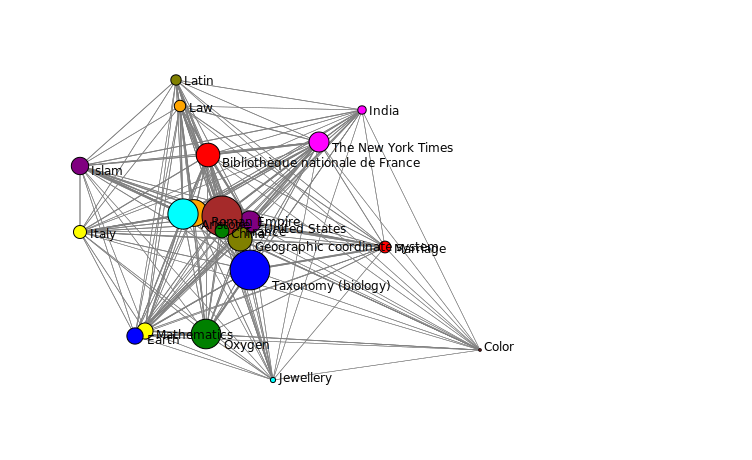

In [ ]:
adjacency_aggregate = louvain.adjacency_
average = normalize(membership_matrix(labels).T)
labels_unique, counts = np.unique(labels, return_counts=True)
image = svg_graph(adjacency_aggregate, names=top_pages, labels=labels_unique, display_node_weight=True)
SVG(image)

In [ ]:
A = adjacency_aggregate.toarray()
strengths = np.diag(A) / np.sum(A,axis=1)
np.argmax(strengths)

2

In [ ]:
top_pages[2]

'Oxygen'

In [ ]:
np.argmax(-strengths)

19

In [ ]:
top_pages[19]

'Color'

## 3. Bigraphs

## Cinema

In [ ]:
graph = cinema

In [ ]:
biadjacency = graph.biadjacency
movies = graph.names_row
actors = graph.names_col

In [ ]:
biadjacency

<88440x44586 sparse matrix of type '<class 'numpy.bool_'>'
	with 304006 stored elements in Compressed Sparse Row format>

In [ ]:
len(movies)

88440

In [ ]:
len(actors)

44586

## To do

* Cluster the graph by Louvain (resolution 1). Use ``BiLouvain``.
* List the 10 largest clusters and display the names of the top-5 actors and top-5 movies of each cluster in terms of Personalized BiPageRank.

In [ ]:
bilouvain = BiLouvain(resolution=1.0)
bilouvain.fit(biadjacency)
labels_row = bilouvain.labels_row_
labels_col = bilouvain.labels_col_

In [ ]:
for k in range(10):
  indexes_row = np.argwhere(labels_row==k).flatten()
  indexes_col = np.argwhere(labels_col==k).flatten()
  seeds_row = {}
  for i in indexes_row:
    seeds_row[i]=1
  seeds_col = {}
  for i in indexes_col:
    seeds_col[i]=1
  bipagerank = BiPageRank()
  bipagerank.fit(biadjacency,seeds_row=seeds_row,seeds_col=seeds_col)
  scores_col = bipagerank.scores_col_
  scores_row = bipagerank.scores_row_
  print("Top-5 actors of cluster "+str(k)+" : ",actors[np.argsort(-scores_col)[:5]])
  print("Top-5 movies of cluster "+str(k)+" : ",movies[np.argsort(-scores_row)[:5]])

Top-5 actors of cluster 0 :  ['Eric Roberts' 'Donald Sutherland' 'Harvey Keitel' 'Danny Trejo'
 'Robert De Niro']
Top-5 movies of cluster 0 :  ['The Walking Dead (TV series)' 'Arrow (TV series)'
 'House of Cards (U.S. TV series)' 'Vikings (TV series)' 'Twin Peaks']
Top-5 actors of cluster 1 :  ['Harry Carey' 'Blanche Sweet' 'Roy Rogers' 'Mary Pickford'
 'Lionel Barrymore']
Top-5 movies of cluster 1 :  ['Paramount on Parade' 'Ziegfeld Follies' 'Mourning Becomes Electra'
 'The Crusades' 'Night Life in Hollywood']
Top-5 actors of cluster 2 :  ['Prem Nazir' 'Jagathy Sreekumar' 'Adoor Bhasi' 'Mammootty' 'Mohanlal']
Top-5 movies of cluster 2 :  ['Suyamvaram' 'Kerala Cafe' 'Paalayam' "Karinkunnam 6'S" 'Lokanathan IAS']
Top-5 actors of cluster 3 :  ['Louis de Funès' 'Isabelle Huppert' 'Marcello Mastroianni' 'Totò'
 'Gérard Depardieu']
Top-5 movies of cluster 3 :  ['Kaamelott' 'Hero Corp' 'Un village français' 'Scènes de ménages'
 'Tatort']
Top-5 actors of cluster 4 :  ['Christopher Lee' 'Stewa

In [ ]:
labels = louvain.labels_col_

In [ ]:
labels_unique, counts = np.unique(labels,return_counts=True)

In [ ]:
indexes = np.argwhere(labels==0)

In [ ]:
counts

array([10883,  4517,  2262,  3850,  4194,  3153,  1816,  1358,  1563,
         839,   736,   410,   324,   578,   504,   564,   369,   272,
         284,   296,   248,    82,   191,   229,   217,   108,    89,
         208,   242,   208,   189,    89,   123,   133,   136,   108,
          85,    79,    61,    88,    81,    57,    58,    52,    49,
          57,    69,    44,    48,    49,    48,    66,    10,    25,
          55,    42,    47,    48,    20,    38,    48,    42,    43,
          37,    32,    42,    42,    25,    30,    38,    25,    11,
          26,    27,    28,    25,    30,    29,    28,    25,    27,
          25,    21,    28,    20,    28,    21,    17,    18,    24,
          20,    24,    20,    18,    22,    20,    11,     6,    16,
          13,    17,    11,    15,    16,     9,    15,     6,     3,
           3,    10,     8,    12,    13,    11,     9,     9,     3,
           9,     7,     9,     6,     8,     4,     8,     6,     7,
           6,     5,

In [ ]:
seeds = np.zeros(len(movies))

In [ ]:
seeds[indexes]=1

In [ ]:
pagerank = BiPageRank()

In [ ]:
pagerank.fit_transform(biadjacency,seeds)

array([1.16174031e-06, 2.85059431e-05, 1.31371817e-05, ...,
       4.20503763e-07, 1.17216108e-06, 5.85418095e-06])